<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_4_gan_semi_supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GANS for Semi-Supervised Training 

Semi-Supervised Learning with Generative Adversarial Networks 은 2016년에 소개된 논문이다. 

GAN 은 준지도 학습으로 사용될 수 있다. 일반적으로 GAN 은 비지도 학습 기법으로 사용이 되는데, 그 이유는 학습데이터의 Ground Truth 가 없기 때문이다. 준지도 학습기법이란 소수의 데이터가 레이블이 달려있거나 그 이외 많은 데이터들이 레이블이 없는 데이터의 쌍을 학습하여서 추론시, Unlabeled 데이터의 라벨링을 예측하는 것을 의미한다.  


**Figure 11.TTYPE: Supervised, UnSupervised and Semi-Supervised**
![GAN](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/gan-training.png "GAN")




기본적으로 지도학습에서 라베이 안된 데이터는 버려졌지만, 준지도 학습기법에서는 모델의 핵심 목적을 수행하는데 인사이트를 줄 수 있습니다. Semi-supervised GAN 은 분류 문제 또는 회귀 문제 모두 동작합니다. 본 논문에서는 판별자로 하여금 출력의 기능을 하게 함으로써 준지도 기법을 수행합니다. 


### Semi-Supervised Classification Training

Figure 2 는 SGAN 이 분류목적을 어떻게 수행하는 지를 보여줍니다. 

**Figure 2.GAN-SEMI: GAN for Semisupervised Training**
![GAN for Semisupervised Training](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/gan-semi-class.png "GAN for Semisupervised Training")


In [15]:
# example of semi-supervised gan for mnist
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Lambda
from keras.layers import Activation
from matplotlib import pyplot
from keras import backend

본 코드 구현에서는 MNIST handwritten digit dataset 분류를 위한 SGAN 구현을 하도록 하겠습니다. 

판별자로 stacked discriminator model을 사용할 것입니다. 생성자의 경우 잠재 공간의 인풋 포인트를 입력받고 컨볼루션 레이어를 사용합니다. 

define_generator() 함수는 생성 모델을 반환합니다.

In [4]:
# define the standalone generator model
def define_generator(latent_dim):
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((7, 7, 128))(gen)
	# upsample to 14x14
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
	# define model
	model = Model(in_lat, out_layer)
	return model

The define_gan() 함수는 generator 와  discriminator models 을 인풋으로 사용하여, 생성자의 가중치를 훈련시키기 위한 혼합 모델을 Return 합니다.

In [5]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect image output from generator as input to discriminator
	gan_output = d_model(g_model.output)
	# define gan model as taking noise and outputting a classification
	model = Model(g_model.input, gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [6]:
# load the images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	print(X.shape, trainy.shape)
	return [X, trainy]

In [7]:
# select a supervised subset of the dataset, ensures classes are balanced
def select_supervised_samples(dataset, n_samples=100, n_classes=10):
	X, y = dataset
	X_list, y_list = list(), list()
	n_per_class = int(n_samples / n_classes)
	for i in range(n_classes):
		# get all images for this class
		X_with_class = X[y == i]
		# choose random instances
		ix = randint(0, len(X_with_class), n_per_class)
		# add to list
		[X_list.append(X_with_class[j]) for j in ix]
		[y_list.append(i) for j in ix]
	return asarray(X_list), asarray(y_list)

In [8]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

In [9]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	z_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = z_input.reshape(n_samples, latent_dim)
	return z_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict(z_input)
	# create class labels
	y = zeros((n_samples, 1))
	return images, y


The summarize_performance() 매 에폭마다 실행하여 분류 성능을 기록합니다. 

In [10]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, c_model, latent_dim, dataset, n_samples=100):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(100):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename1 = 'generated_plot_%04d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# evaluate the classifier model
	X, y = dataset
	_, acc = c_model.evaluate(X, y, verbose=0)
	print('Classifier Accuracy: %.3f%%' % (acc * 100))
	# save the generator model
	filename2 = 'g_model_%04d.h5' % (step+1)
	g_model.save(filename2)
	# save the classifier model
	filename3 = 'c_model_%04d.h5' % (step+1)
	c_model.save(filename3)
	print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))

훈련함수의 배치사이즈는 100, 에폭은 20 으로 초기화하도록 하겠습니다. 준지도 학습 기법의 훈련함수는 거의 vanila GAN 과 비슷하며, 레이블 정보도 함께 학습 시켜 준다는 점이 다릅니다. 


In [11]:
# train the generator and discriminator
def train(g_model, d_model, c_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=100):
	# select supervised dataset
	X_sup, y_sup = select_supervised_samples(dataset)
	print(X_sup.shape, y_sup.shape)
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs, n_batch, half_batch, bat_per_epo, n_steps))
	# manually enumerate epochs
	for i in range(n_steps):
		# update supervised discriminator (c)
		[Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
		c_loss, c_acc = c_model.train_on_batch(Xsup_real, ysup_real)
		# update unsupervised discriminator (d)
		[X_real, _], y_real = generate_real_samples(dataset, half_batch)
		d_loss1 = d_model.train_on_batch(X_real, y_real)
		X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		d_loss2 = d_model.train_on_batch(X_fake, y_fake)
		# update generator (g)
		X_gan, y_gan = generate_latent_points(latent_dim, n_batch), ones((n_batch, 1))
		g_loss = gan_model.train_on_batch(X_gan, y_gan)
		# summarize loss on this batch
		print('>%d, c[%.3f,%.0f], d[%.3f,%.3f], g[%.3f]' % (i+1, c_loss, c_acc*100, d_loss1, d_loss2, g_loss))
		# evaluate the model performance every so often
		if (i+1) % (bat_per_epo * 1) == 0:
			summarize_performance(i, g_model, c_model, latent_dim, dataset)

본 논문에서는 출력 함수를 명확하게 하기 위하여 활성화 함수를 정의합니다.

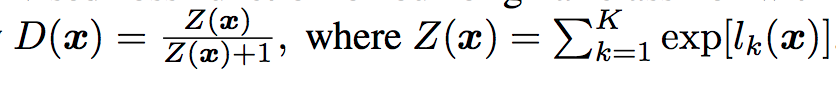

In [13]:
# custom activation function
def custom_activation(output):
	logexpsum = backend.sum(backend.exp(output), axis=-1, keepdims=True)
	result = logexpsum / (logexpsum + 1.0)
	return result
 
# define the standalone supervised and unsupervised discriminator models
def define_discriminator(in_shape=(28,28,1), n_classes=10):
	# image input
	in_image = Input(shape=in_shape)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(in_image)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output layer nodes
	fe = Dense(n_classes)(fe)
	# supervised output
	c_out_layer = Activation('softmax')(fe)
	# define and compile supervised discriminator model
	c_model = Model(in_image, c_out_layer)
	c_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
	# unsupervised output
	d_out_layer = Lambda(custom_activation)(fe)
	# define and compile unsupervised discriminator model
	d_model = Model(in_image, d_out_layer)
	d_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
	return d_model, c_model

In [16]:
# size of the latent space
latent_dim = 100
# create the discriminator models
d_model, c_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, c_model, gan_model, dataset, latent_dim)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1) (60000,)
(100, 28, 28, 1) (100,)
n_epochs=20, n_batch=100, 1/2=50, b/e=600, steps=12000
>1, c[2.306,4], d[0.097,2.399], g[0.095]
>2, c[2.308,14], d[0.093,2.398], g[0.095]
>3, c[2.291,12], d[0.089,2.398], g[0.095]
>4, c[2.270,26], d[0.085,2.400], g[0.095]
>5, c[2.286,22], d[0.080,2.403], g[0.095]
>6, c[2.259,26], d[0.077,2.404], g[0.095]
>7, c[2.248,22], d[0.077,2.401], g[0.096]
>8, c[2.281,16], d[0.077,2.391], g[0.098]
>9, c[2.232,30], d[0.080,2.380], g[0.099]
>10, c[2.177,34], d[0.081,2.374], g[0.099]
>11, c[2.208,26], d[0.080,2.374], g[0.099]
>12, c[2.154,40], d[0.080,2.377], g[0.099]
>13, c[2.165,28], d[0.074,2.371], g[0.100]
>14, c[2.088,38], d[0.067,2.352], g[0.103]
>15, c[2.089,42], d[0.055,2.330], g[0.105]
>16, c[2.041,42], d[0.044,2.317], g[0.107]
>17, c[2.111,30], d[0.037,2.312], g[0.107]
>18, c[2.023,38], d[0.031,2.303], g[0.109]
>19, c[1.966,46], d[0.028,2.285], g[0.115]
>20, c[1.934,46], d[0

KeyboardInterrupt: ignored